In [1]:
import pandas as pd
import numpy as np
import pdfplumber
import re
import os
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

### Test first page

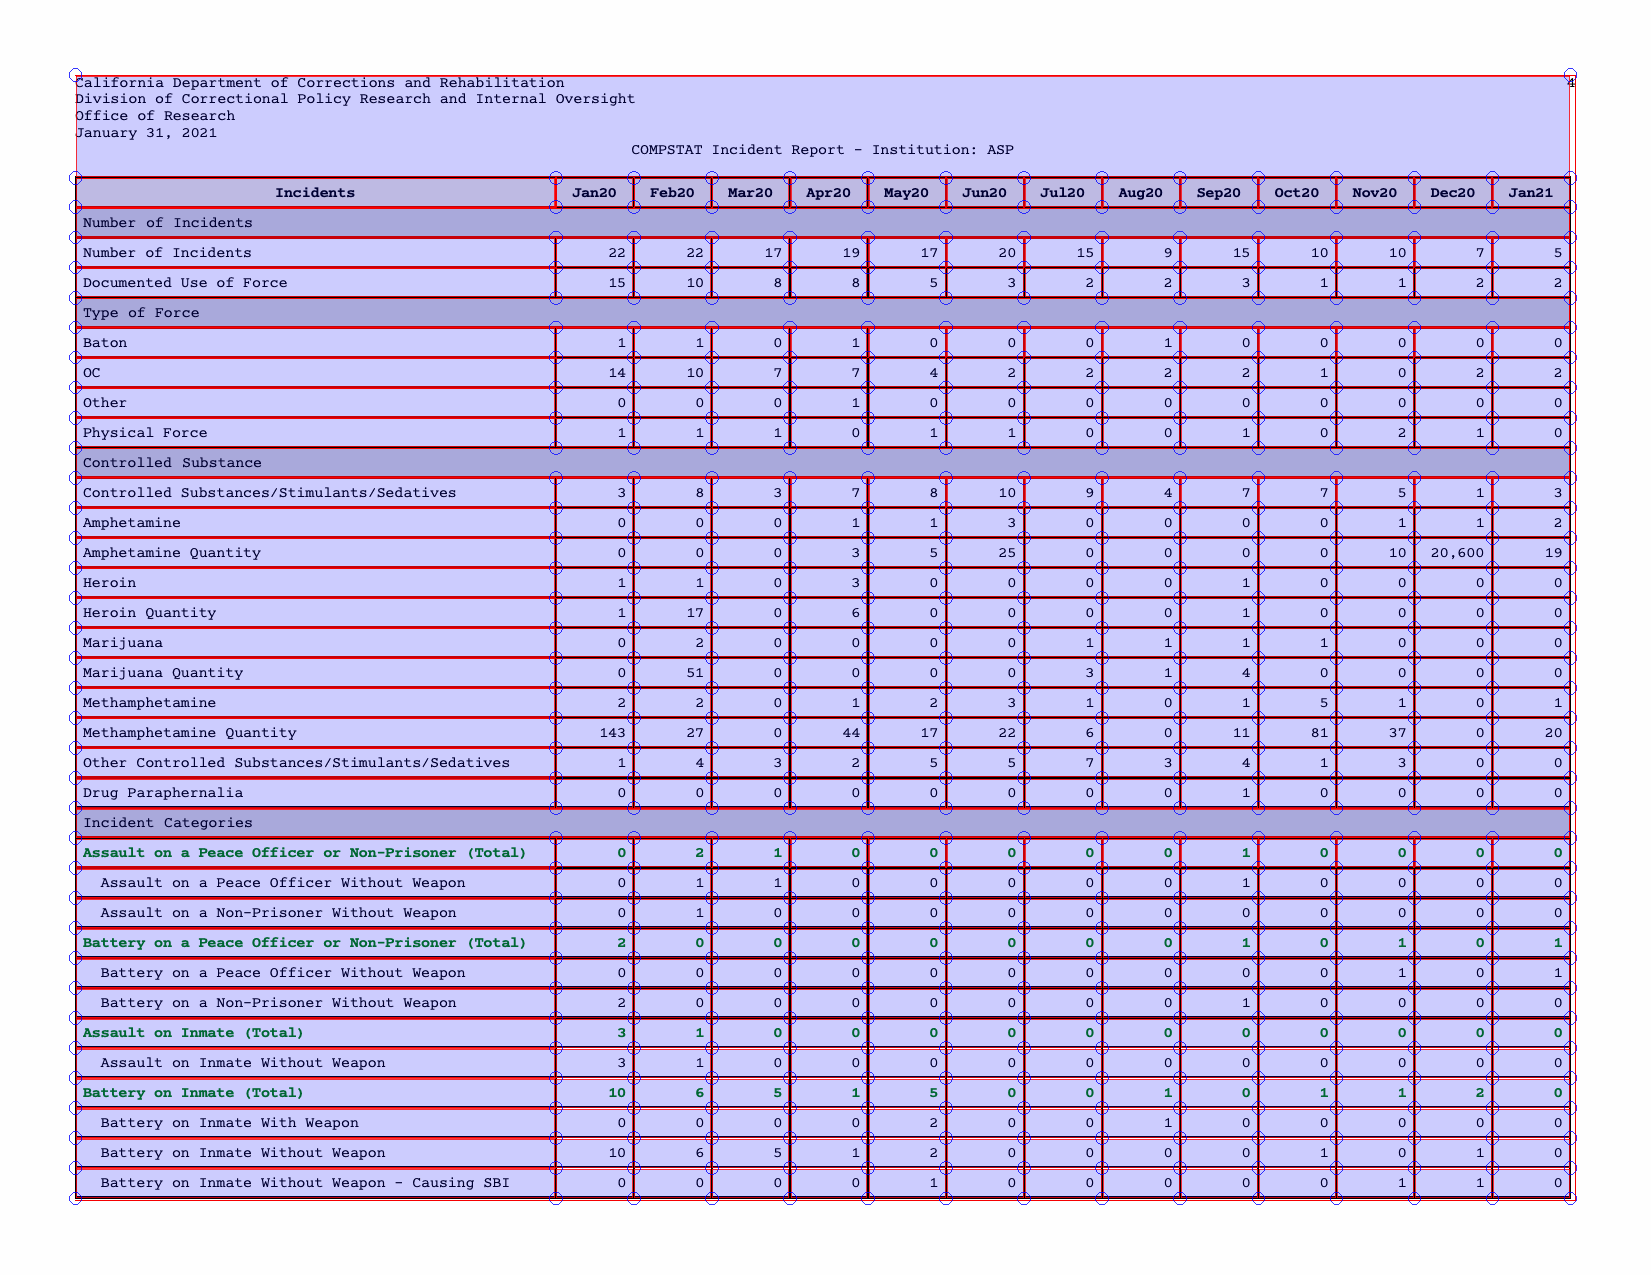

In [2]:
#test first page
pdf = pdfplumber.open("pdfs-2020-to-2023-incidents/CompStat_Incident_Report_d2101.pdf")
first_page = pdf.pages[3]
im = first_page.to_image(resolution=150)
im.reset().debug_tablefinder()

### Find header row

(note on some PDFs, plumber picks up an addition row so it's either on index 1 or 0

In [ ]:
first_page.extract_table()
#first_page.crop((415,65,550,80)).to_image(resolution=150)

In [3]:

def parse_value(x):
    if x == "": return np.nan
    if x == None: return np.nan
    return x.replace(',', '').replace('\n', ' ')

df = pd.DataFrame()

#pdf_files = sorted((f for f in os.listdir("pdfs-2020-to-2023-incidents") if not f.startswith(".")), key=str.lower)
pdf_files = [
    "CompStat_Incident_Report_d2101.pdf",
    "CompStat_Incident_Report_d2201.pdf",
    "CompStat_Incident_Report_d2301.pdf",
    "CompStat_Incident_Report_d2310.pdf"
]

for pdf_file in pdf_files:

    pdf = pdfplumber.open("pdfs-2020-to-2023-incidents/" + pdf_file)

    #set globally because sometimes header rows continue on to next page
    subcategory = ''

    pbar1 = tqdm(total=len(pdf.pages[3:]), position=0, leave=False)
    
    #loop through each page
    for k,page in enumerate(pdf.pages[3:]):
        table         = page.extract_table()
        institution   = re.sub(r'^.*?:\s(\w+).*?$', r'\1', page.crop((415, 70, 500, 80)).extract_text())

        pbar1.update(1) #update progress bar for which pdf we're on
        pbar1.set_description("Processing Page: %s out of %s" % (k+1, len(pdf.pages[3:])))

        #some of the PDFs the headers are on 0 others are on 1. Header always starts with Incidents though
        if table[1][0] == 'Incidents':
            this_pages_headers = table[1][1:] 

        if table[0][0] == 'Incidents':
            this_pages_headers = table[0][1:] 
         
        for row in table:

            if re.search(r'^California Department of Corrections.*?', row[0]):
                continue

            if row[0] == 'Incidents':
                continue

            #if all cells except first one are None, it's a heading row
            if all(cell == None for cell in row[1:]):
                subcategory = row[0]
            else:
                row_object  = {'Subcategory': subcategory, 'Institution': institution, 'Metric Title': row[0]}

                #2023 pdf is partial, so we need a different slice
                if pdf_file == "CompStat_Incident_Report_d2310.pdf":
                    iterator     = enumerate(row[4:14])
                    index_offset = 3
                else:
                    iterator     = enumerate(row[1:13])
                    index_offset = 0
                    
                for i,cell in iterator:
                    row_object['Month'] = re.split(r'(\w{3})(\d{2})', this_pages_headers[i + index_offset])[1]
                    row_object['Year']  = '20' + re.split(r'(\w{3})(\d{2})', this_pages_headers[i + index_offset])[2]
                    row_object['Value'] = parse_value(cell)
                    df = pd.concat([df, pd.DataFrame([row_object])], ignore_index=True)

df

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

,Subcategory,Institution,Metric Title,Month,Year,Value
0,Number of Incidents,ASP,Number of Incidents,Jan,2020,22
1,Number of Incidents,ASP,Number of Incidents,Feb,2020,22
2,Number of Incidents,ASP,Number of Incidents,Mar,2020,17
3,Number of Incidents,ASP,Number of Incidents,Apr,2020,19
4,Number of Incidents,ASP,Number of Incidents,May,2020,17
...,...,...,...,...,...,...
89041,Mental Health,WSP,UOF Incidents Involving Mental Health Inmates,Jun,2023,24
89042,Mental Health,WSP,UOF Incidents Involving Mental Health Inmates,Jul,2023,22
89043,Mental Health,WSP,UOF Incidents Involving Mental Health Inmates,Aug,2023,17
89044,Mental Health,WSP,UOF Incidents Involving Mental Health Inmates,Sep,2023,23


In [4]:
df.to_csv("finished-csvs/finished-2020-2023-incidents.csv", encoding="utf-8", index=False)